# Monte Carlo Dropout for Predicting Prices with Deep Learning and Tensorflow Applied to the [IBEX35](https://emea1.apps.cp.thomsonreuters.com/web/Apps/Index/?s=.IBEX&st=RIC&app=true#/)

## Abstract

This article studies the implementation of [the dropout method](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) for predicting returns in [Ibex 35](https://emea1.apps.cp.thomsonreuters.com/web/Apps/Index/?s=.IBEX&st=RIC)'s historical constituents. This methodology produces multiple predictions for the same input data, thus allowing to obtain a standard deviation and a mean for the predictions. Using 100 predictions and a filter based on the standard deviations, some models could generate returns in the test set whereas the first individual prediction of each model lost money during the same period. These results illustrate the usefulness of including uncertainty in predictions. 

In addition, a custom metric was defined for training the models. It is defined to mirror the [Sharpe ratio](https://www.investopedia.com/terms/s/sharperatio.asp) given that standard metrics do not completely reflect reality for deep learning models applied in finance, given the asymmetry in the returns.

Finally, the models are compared using different ratios to compare the returns adjusted for risk, being the simple recurrent neural network model, the worst performing one in the test set. The [LSTM](https://www.tutorialspoint.com/time_series/time_series_lstm_model.htm) and the [GRU](https://d2l.ai/chapter_recurrent-modern/gru.html) with the strictest filter obtained the best results for the ratios considered. The [convolutional 1 D layer](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html#convolutional-layers) performed better than the simple [recurrent neural network model](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html).

### 1. Introduction

Deep learning has shown great advances in multiple fields. In this paper, it is used to make predictions on the next day returns on the constituents of the Ibex 35. One of the great capabilities of deep learning is the automated extraction of features. In that sense, four different models are compared for making predictions using the percentage change of the open, close, high, low and the standard deviation, kurtosis, and skewness of the returns over the last 22 days.

These models always produce a prediction, even when there might be high uncertainty in this prediction. Thus, by computing multiple predictions for each model, it is possible to average the results, and compute the standard deviations to model the uncertainty in this prediction. In this paper it is achieved by randomly deactivating a percentage of the connections in the neural networks, based on GG (Gal and Ghahramani, 2016). Finally, these models are compared with the buy and hold on the Ibex 35 on the test set and with a single prediction of each model.

### 2. Literature review

There is sounding literature studying the application of deep learning for predicting stocks returns. Using monthly data and multiple input variables obtained from Refinitiv, different neural networks structures are capable of predicting returns using MSE as the loss function and dropout layers for regularizing the great amount of parameters with the few data points available (Abe and Nakayama, 2018).

A comparison of different deep learning models and other machine learning algorithms yields the long short-term memory (LSTM)  as the best structure for predicting stock market returns for multiple forecast windows (Nabipour et al., 2020), when evaluated for four regression losses, amongst them, the MSE. In addition, another study on the constituents of the S&P500 shows the LSTM cells as the best performing structure for predicting stock returns (Fischer and Krauss, 2018). Moreover, when using only a few stocks, an LSTM model performed better than a 1D Convolutional layer in terms of MSE.

Nevertheless other studies show the prediction power of a convolutional layer when applied to a few stocks (Sayavong, Wu and Chalita, 2019). In addition, using daily returns from the Chinese stock market, the convolutional layer shows some predictive capacity (Chen and He, 2018).

As for the dropout technique for estimating uncertainty, other authors have proposed different methodologies such as the variational dropout (Molchanov, Ashukha and Vetrov, 2017) or the single shot MC dropout approximation (Brach, Sick and Dürr, 2020).

For comparison the sharpe ratio (Sharpe, 1994), sortino ratio (Sortino and Price, 1994) and the information ratio (Goodwin, 1998) are computed for each model in the test set.

### 3. Methodology and analysis of results

In this part, we start writing the required code. First of all we import the required libraries.

In [1]:
# !pip install tensorflow-gpu==1.15

# # # You might need to run the below:
# # !pip install --upgrade pip
# # !pip install --upgrade tensorflow-gpu

In [2]:
import eikon as ek
import pandas as pd
import sys
import plotly.graph_objects as go
import plotly as pyo
import numpy as np
import warnings
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.experimental.numpy as tnp

The versions of the different libraries are showed to facilitate reproducibility.

In [3]:
print(sys.version) # 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
for i, j in zip(["eikon", "pandas", "numpy", "plotly", "tensorflow"],
                [ek, pd, np, pyo, tf]):
    print(f"The Python library '{i}' imported in this script is version '{j.__version__}'")

3.7.5 (tags/v3.7.5:5c02a39a0b, Oct 15 2019, 00:11:34) [MSC v.1916 64 bit (AMD64)]
The Python library 'eikon' imported in this script is version '1.1.12'
The Python library 'pandas' imported in this script is version '1.3.0'
The Python library 'numpy' imported in this script is version '1.19.5'
The Python library 'plotly' imported in this script is version '5.1.0'
The Python library 'tensorflow' imported in this script is version '2.7.0'


In the next few steps, four neural networks predicting a stock's daily returns are compared. These models are composed of two layers, each one followed by a batch normalization layer (Ioffe and Szegedy, 2015) and a dropout layer (Baldi and Sadowski, n.d.). After that there is fully connected layer and a final fully connected layer which outputs the prediction. The two initial layers have 16 units each, while the next fully connected layer has eight neurons, and the last layer uses only one neuron. The activation function is the hyperbolic tangent for every layer except the last one which uses an exponential linear unit activation (Clevert, Unterthiner and Hochreiter, 2016) to reflect the asymmetry in stocks returns, as the negative return cannot be lower than –100% but the positive returns are not limited. Finally, the dropout is set to 50%.

The four models differ in the type of layer used for the initial two layers. These chosen layers are two simple recurrent neural networks cells, two gated recurrent unit (GRU), two LSTM layers and two one dimension convolutional layers, given its advantages and uses for time series data (Kiranyaz et al., 2021), using a kernel size of five for the convolutional layers.

To create these four models we define the following functions. The training parameter activates the dropout layer during prediction too.

In [4]:
def get_seq_model(neurons = 16, dr = 0.5, act = "tanh", cell = layers.LSTM):
    inputs = layers.Input(shape = (sequence, X_train.shape[1]))
    x = cell(neurons, activation = act, return_sequences = True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = cell(neurons, activation = act)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = layers.Dense(neurons // 2, activation = act)(x)
    outputs = layers.Dense(1, activation = "elu")(x)
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    return model

def get_conv_model(neurons = 16, k = 5, dr = 0.5, act = "tanh"):
    inputs = layers.Input(shape = (sequence, X_train.shape[1]))
    x = layers.Conv1D(neurons, k, activation = act)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = layers.Conv1D(neurons, k, activation = act)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = layers.Dense(neurons // 2, activation = act)(x)
    outputs = layers.Dense(1, activation = "elu")(x)
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    return model

We want to use the data for the constituents of the Ibex 35 from 1995 to 2020. At the start of each year, those companies listed in the index are added to the study from that day onwards.

We will set the key for the API, this key is obtained using the Eikon APP to generate keys. Note that an instance of [Workspace](https://www.refinitiv.com/en/products/refinitiv-workspace) or [Eikon](https://www.refinitiv.com/en/products/eikon-trading-software) needs to run on your machine for the cel below to work.

In [5]:
# The key is placed in a text file so that it may be used in this code without showing it itself:
eikon_key = open("eikon.txt","r")
ek.set_app_key(str(eikon_key.read()))
# It is best to close the files we opened in order to make sure that we don't stop any other services/programs from accessing them if they need to:
eikon_key.close()

The dates defined for the study are stored in the variable dates.

In [6]:
dates = pd.date_range('1995', '2020', freq = 'YS')

We define the required fields for our study, we define a dataframe that will be filled with the constituents of the Ibex 35. In addition, we declare the constituents of the Ibex 35. We need at least one field to obtain the data, in this case the GICS sector was chosen.

In [7]:
df_full = pd.DataFrame()
chain = "0#.IBEX" # Constituents of the Ibex 35
fields = ["TR.GICSSector"]

Then we fill this dataframe.

In [8]:
for date in dates:
    year = int(str(date.to_period('Y')))
    day = f"{year}-01-01"
    params = {'SDate': day, "EDate": day, "Frq": "FY"} 

    # We obtain the constituents of the Ibex 35 at the start 
    # of each year and store that date as a column

    df = ek.get_data(f'{chain}({day})', fields, params)[0]
    df["Date"] = f'{date.to_period("D")}'

    # Then we drop the missing values and store them in
    # the previously created dataframe

    df = df.replace('', np.nan).dropna()
    df_full = df_full.append(df)

We already have a dataframe containing the historical consitituents of the Ibex 35 and the dates when they were listed in the index. We want to obtain another dataframe containing the daily returns of each company since the date they were already part of the Ibex 35. In addition, given that the get_timeseries function of eikon only returns 3000 data points, we take only 10 years with each connection. As, the high, low, close and volume information were not available until the market closed we shift that data one day. Moreover, we compute the daily percentage of change of the open price and create additional columns computing rolling statistical measures of these changes. Finally we create another column containing the next day percentage of change of the open, which will be used for training the neural networks.

There are a few companies for which data is not available, thus we ignore those stocks.

In [9]:
df_full.T

0           1           2           3           7   \
Instrument         ABE.MC^H18      ANA.MC      ACX.MC  AGS.MC^F10  BTO.MC^E13   
GICS Sector Name  Industrials   Utilities   Materials   Utilities  Financials   
Date               1995-01-01  1995-01-01  1995-01-01  1995-01-01  1995-01-01   

                          9           10          11           14          15  \
Instrument            SAN.MC      BKT.MC     BBVA.MC      CCMC.MC      ALB.MC   
GICS Sector Name  Financials  Financials  Financials  Industrials  Financials   
Date              1995-01-01  1995-01-01  1995-01-01   1995-01-01  1995-01-01   

                  ...          25                      26  \
Instrument        ...      MAP.MC                  TL5.MC   
GICS Sector Name  ...  Financials  Communication Services   
Date              ...  2020-01-01              2020-01-01   

                                      27           28          29          30  \
Instrument                        MEL.MC       MRL.MC     NTGY.MC      REE.MC   
GICS Sector Name  Consumer Discretionary  Real Estate   Utilities   Utilities   
Date                          2020-01-01   2020-01-01  2020-01-01  2020-01-01   

                          31           32                      33  \
Instrument            REP.MC     SGREN.MC                  TEF.MC   
GICS Sector Name      Energy  Industrials  Communication Services   
Date              2020-01-01   2020-01-01              2020-01-01   

                                34  
Instrument                  VIS.MC  
GICS Sector Name  Consumer Staples  
Date                    2020-01-01  

[3 rows x 733 columns]

In [10]:
# We store the names of the companies and the year they were listed in the index.
stocks = df_full.groupby("Instrument")["Date"].min().index
starts = df_full.groupby("Instrument")["Date"].min()
df_ts = pd.DataFrame() # We will fill this dataframe with all the data

In [11]:
# This lambda function takes a year and returns that date for the next step years
step = 10
to_date = lambda x: (f"{x}-01-01", f"{x+step}-12-31")

# e.g.:
[to_date(x) for x in range(2000, 2020, step)]

[('2000-01-01', '2010-12-31'), ('2010-01-01', '2020-12-31')]

In [12]:
cols = ['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VOLUME']

for stock, start in zip(stocks, starts):
    year = int(start[:4])
    date_range = [to_date(x) for x in range(year, 2020, step)]
    for st, end in date_range:
        try:
            df = ek.get_timeseries(stock, cols, start_date=st, end_date = end, interval = "daily")
        except ek.EikonError:
            try:
                df = ek.get_timeseries(stock, cols, start_date=st, end_date = None, interval = "daily")
            except ek.EikonError:
                continue
        df["stock"] = stock
        df[cols[1:]] = df[cols[1:]].pct_change().shift(1)
        df["target"] = df["OPEN"].pct_change().shift(-1)
        df["OPEN"] = df["OPEN"].pct_change()

        # We create a multi-index appending the identifier of the stock to the 'dates' index.
        df = df.set_index("stock", append = True)
        df_ts = df_ts.append(df.dropna())

# Finally we sort the data by its index
df_ts = df_ts.sort_index()

2021-12-01 10:59:18,816 P[23380] [MainThread 10316] Error with AGS.MC^F10: No data available for the requested date range
2021-12-01 10:59:18,818 P[23380] [MainThread 10316] AGS.MC^F10: No data available for the requested date range | 
2021-12-01 10:59:19,234 P[23380] [MainThread 10316] Error with AGS.MC^F10: No data available for the requested date range
2021-12-01 10:59:19,235 P[23380] [MainThread 10316] AGS.MC^F10: No data available for the requested date range | 
2021-12-01 10:59:28,094 P[23380] [MainThread 10316] Error with BTO.MC^E13: No data available for the requested date range
2021-12-01 10:59:28,096 P[23380] [MainThread 10316] BTO.MC^E13: No data available for the requested date range | 
2021-12-01 10:59:28,280 P[23380] [MainThread 10316] Error with BTO.MC^E13: No data available for the requested date range
2021-12-01 10:59:28,281 P[23380] [MainThread 10316] BTO.MC^E13: No data available for the requested date range | 
2021-12-01 10:59:29,832 P[23380] [MainThread 10316] Erro

In [13]:
df_ts

OPEN     CLOSE      HIGH       LOW    VOLUME  \
Date       stock                                                          
1995-01-04 ABE.MC^H18 -0.004785       0.0  0.014563       0.0  0.482483   
           ACX.MC      0.014588  0.017608 -0.007857  0.008088       3.0   
           AGS.MC^F10    -0.008   0.00616   0.02459  0.040598   0.25356   
           ALB.MC      0.030909  -0.02087 -0.020833 -0.003623  6.677046   
           ANA.MC           0.0   0.01087  0.001065  0.010977 -0.108819   
...                         ...       ...       ...       ...       ...   
2021-11-30 TEF.MC      0.002033  0.013431  0.009743  0.013635 -0.381762   
           TL5.MC      0.016548 -0.000945  0.009745  0.005299 -0.221288   
           TRE.MC      -0.03467 -0.019178 -0.017775 -0.020619  0.366044   
           TUBA.MC    -0.013977  0.012658  -0.01227  0.006394 -0.655624   
           VIS.MC     -0.018341 -0.005254 -0.010354 -0.007944  0.183329   

                         target  
Date       stock                 
1995-01-04 ABE.MC^H18 -0.019231  
           ACX.MC     -0.001438  
           AGS.MC^F10 -0.008065  
           ALB.MC     -0.010582  
           ANA.MC           0.0  
...                         ...  
2021-11-30 TEF.MC      0.013968  
           TL5.MC     -0.009767  
           TRE.MC     -0.015493  
           TUBA.MC     0.015464  
           VIS.MC       0.00089  

[278574 rows x 6 columns]

The obtained data is transformed to numpy and transformed to be between 0 and 1 in the training set. In addition, it is divided into the training set from the start of 1995 to the end of 2011, the validation set from the start of 2012 to the end 2015 and finally the test set, which goes from the start of 2016 to the end of 2020.

In [14]:
for col in df_ts.columns:
    df_ts[col] = df_ts[col].astype(np.float32)

cols = df_ts.drop(columns = "target").columns

X_train = df_ts.loc[:"2011", slice(None), :].drop(columns = "target")
df_ts[cols] = (df_ts[cols] - X_train.min()) / (X_train.max() - X_train.min())

In [15]:
df_ts

OPEN     CLOSE      HIGH       LOW    VOLUME  \
Date       stock                                                          
1995-01-04 ABE.MC^H18  0.138891  0.124589  0.135446  0.138627  0.000402   
           ACX.MC      0.147235  0.132381  0.125412  0.142189  0.001086   
           AGS.MC^F10  0.137506  0.127315  0.139934  0.156507  0.000340   
           ALB.MC      0.154264  0.115353  0.119605  0.137031  0.002084   
           ANA.MC      0.140952  0.129399  0.129405  0.143461  0.000242   
...                         ...       ...       ...       ...       ...   
2021-11-30 TEF.MC      0.141828  0.130533  0.133289  0.144631  0.000168   
           TL5.MC      0.148079  0.124171  0.133290  0.140960  0.000211   
           TRE.MC      0.126020  0.116102  0.120973  0.129546  0.000371   
           TUBA.MC     0.134932  0.130191  0.123437  0.141443  0.000093   
           VIS.MC      0.133053  0.122264  0.124295  0.135128  0.000321   

                         target  
Date       stock                 
1995-01-04 ABE.MC^H18 -0.019231  
           ACX.MC     -0.001438  
           AGS.MC^F10 -0.008065  
           ALB.MC     -0.010582  
           ANA.MC      0.000000  
...                         ...  
2021-11-30 TEF.MC      0.013968  
           TL5.MC     -0.009767  
           TRE.MC     -0.015493  
           TUBA.MC     0.015464  
           VIS.MC      0.000890  

[278574 rows x 6 columns]

In [16]:
X_train = df_ts.loc[:"2011", slice(None), :].drop(columns = "target")
y_train = df_ts.loc[:"2011", slice(None), :].pop("target")
X_val = df_ts.loc["2012":"2015", slice(None), :].drop(columns = "target")
y_val = df_ts.loc["2012":"2015", slice(None), :].pop("target")
X_test = df_ts.loc["2016":, slice(None), :].drop(columns = "target")
y_test = df_ts.loc["2016":, slice(None), :].pop("target")
X_full = df_ts.drop(columns = "target")

We will create sequences of data of 22 days that will be used as input for the neural networks.

In [17]:
sequence = 22
batch = 256
stocks = df_ts.index.get_level_values(1).unique()

We prepare the data, and store it as tensorflow datasets.

In [18]:
loc = lambda x, s: x.loc[slice(None), s, :]
to_ds = lambda x, y: tf.keras.preprocessing.timeseries_dataset_from_array(
    x, y, sequence_length=sequence, batch_size=batch)

ds_train = to_ds(loc(X_train, stocks[0]), loc(y_train, stocks[0]))
ds_val = to_ds(loc(X_val, stocks[0]), loc(y_val, stocks[0]))
ds_test = to_ds(loc(X_test, stocks[0]), loc(y_test, stocks[0]))
ds_err = {'train': [], 'val': [], 'test': []}

for stock in stocks[1:]:
    try:
        ds_train = ds_train.concatenate(to_ds(loc(X_train, stock), loc(y_train, stock)))
    except KeyError as err:
        ds_err['train'].append(err)
    try:
        ds_val = ds_val.concatenate(to_ds(loc(X_val, stock), loc(y_val, stock)))
    except KeyError as err:
        ds_err['val'].append(err)
    try:
        ds_test = ds_test.concatenate(to_ds(loc(X_test, stock), loc(y_test, stock)))
    except KeyError as err:
        ds_err['test'].append(err)
        continue

A custom loss is defined by attempting to mirror the sharpe ratio assuming 0% risk free returns, 0.25% trading commissions, and adding a little constant to the denominator to avoid division by zero.

In [19]:
def loss(y_true, y_pred):
    dif =  - tf.reduce_mean(y_true * y_pred - 0.0025 * tf.math.abs(y_pred)) /  (tf.math.reduce_std(y_true * y_pred) + 1e-10) 
    return dif

In addition, we want to stop the training if the loss of this model does not improve at least 0.01 for 15 consecutive epochs in the validation set or 7 consecutive epochs in the training set, restoring the weights that achieved the lowest loss

In [20]:
early_stop_val = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    verbose=0, 
    restore_best_weights=True,
    min_delta = 0.01
)

early_stop_train = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=7, 
    verbose=0, 
    restore_best_weights=True,
    min_delta = 0.01
)

Finally, we want to schedule the learning rate during training. It will increase for the first 10 epochs and after that, the learning rate starts to decrease using an expontential function.

In [21]:
def lr_sc(ep, lr):
    if ep <= 10 : return 1.1*lr
    return lr * tf.math.exp(-(ep-10) / 100)

mod_lr = tf.keras.callbacks.LearningRateScheduler(lr_sc)

Finally, these models are trained using the RMSprop optimizer for a maximum of 100 epochs. The starting learning rate is set to 0.0003. We set the seed to 0 for reproducible results. Even though the neural networks are trained using multiprocessing (it is possible because the data was converted to a tensorflow dataset) it might take some time until the training ends.

In [22]:
history = []
models = [get_seq_model(cell = layers.SimpleRNN), get_seq_model(cell = layers.GRU), 
          get_seq_model(), get_conv_model()]

tf.random.set_seed(0)

for model in models:
    tf.keras.backend.clear_session()
    optimizer=tf.optimizers.RMSprop(3e-4)
    model.compile(optimizer = optimizer, loss = loss)
    history.append(
        model.fit(
            ds_train,
            epochs = 100, 
            validation_data=ds_val, 
            verbose = 0, # This value can be increased to visualize the progress.
            callbacks = [early_stop_val, mod_lr, early_stop_train],
            use_multiprocessing = True,
            )
        )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:00:23,849 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000029B8162A8B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:00:23,967 P[23380] [MainThread 10316] AutoGraph could not transform <function loss at 0x0000029B801EB708> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:00:34,117 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000029B801EB948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:09:38,903 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000029B846DC4C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:09:55,658 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000029B89BE6798> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:20:27,786 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000029B9053AD38> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:20:43,805 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000029B925988B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:32:05,850 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000029B92F6C4C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:32:14,504 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000029B9806C168> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


To make the predictions of the models we define a function that takes the number of predictions that we want to average. We store the average and the standard deviations of the predictions and the first prediction is also stored for comparison.

In [23]:
def make_predictions(samples = 100):
    stocks = X_full.index.get_level_values(1).unique()
    for i, stock in enumerate(stocks):
        for m, model in enumerate(models):
            data = to_ds(X_full.loc[(slice(None), stock), :], None)
            predictions = [model.predict(data, use_multiprocessing = True) for _ in range(samples)]
            mean = np.append([np.nan]*(sequence - 1), tf.reduce_mean(predictions, axis = 0).numpy())
            std = np.append([np.nan]*(sequence - 1), tf.math.reduce_std(predictions, axis = 0).numpy())
            first = np.append([np.nan]*(sequence - 1), predictions[0])
            df_ts.loc[(slice(None), stock), f"pred_mean_{m}"] = mean
            df_ts.loc[(slice(None), stock), f"pred_{m}"] = first
            df_ts.loc[(slice(None), stock), f"pred_std_{m}"] = std
        if (i % 5 == 0): print(f"{100*i/len(stocks):.2f} %")

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    make_predictions()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:39:10,620 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x0000029B984844C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:39:30,267 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x0000029B98484798> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:39:54,699 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x0000029B984A2E58> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 11:40:22,214 P[23380] [MainThread 10316] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x0000029B98568048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.00 %
8.93 %
17.86 %
26.79 %
35.71 %
44.64 %
53.57 %
62.50 %
71.43 %
80.36 %
89.29 %
98.21 %


Each day we take the sum of the absolute of the predictions and divide each prediction by this number, thus the sum of these weighted predictions is one.

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for m, model in enumerate(models):
        df_ts[f"pred_weighted_{m}"] = df_ts.groupby("Date")[f"pred_{m}"].apply(lambda x: x / (x.abs().sum()))

Finally, we compute the trading costs of 0.01% and define a few lambda functions to compute all the results. 

In [29]:
cps = 0.0001
names = ["SimpleRNN", "GRU", "LSTM", "Convolutional"]

mask = lambda x, y : (df_ts.dropna()[f"pred_std_{x}"] * y < df_ts.dropna()[f"pred_mean_{x}"].abs()) 
r_mean = lambda x, y: (df_ts.dropna()[mask(x, y)].groupby("Date")[f"pred_mean_{x}"].apply(lambda z: z / (np.sum(np.abs(z)))) * df_ts.dropna()[mask(x, y)]["target"]).groupby("Date").sum()
costs_mean = lambda x, y: (df_ts.dropna()[mask(x, y)].groupby("stock")[f"pred_mean_{x}"].apply(lambda z: z / (np.sum(np.abs(z)))).diff(1).abs() * cps).groupby("Date").sum()
r_mean_total = lambda x, y: r_mean(x, y) - costs_mean(x, y)
r_single = lambda x: (df_ts.dropna()[f"pred_weighted_{x}"] * df_ts.dropna()["target"]).groupby("Date").sum()
costs_single = lambda x: (df_ts.dropna().groupby("stock")[f"pred_weighted_{x}"].diff(1).abs() * cps).groupby("Date").sum()
r_single_total = lambda x: r_single(x) - costs_single(x)

In [56]:
# # Setting up sigma range up to a max of 10:

max_sigma_l = []
for x in range(len(names)):
    max_sigma = 0
    while True in (mask(x, max_sigma + 1)).to_list() and max_sigma < 10:
        max_sigma += 1
    max_sigma_l.append(max_sigma)
max_sigma = min(max_sigma_l)

if max_sigma >= 10: sigmas = [0, 2, 3, 5, 10]
elif max_sigma > 5: sigmas = [0, 2, 3, 5, max_sigma]
elif max_sigma <= 5:
    sigmas = [0, 2, 3, 5]
    print(f"Have too few sigmas, only up to {max_sigma}")

In [57]:
rets_mean = [r_mean_total(x, sigma) + 1 for x, _ in enumerate(names) for sigma in sigmas]

In [58]:
rets_single = [r_single_total(x) + 1 for x, _ in enumerate(names)]

names_mean = ["Average prediction " + name + f" {y} sigmas filter" for name in names for y in sigmas]
names_single = ["Single prediction " + name for name in names]

For comparison we also take the data of the index in a variable.

In [59]:
df_ibex = ek.get_timeseries(chain[2:], "OPEN", start_date="2016-01-01", end_date = "2020-12-31", interval = "daily")
df_ibex["OPEN"] = df_ibex["OPEN"].pct_change()

rets_b = df_ibex.dropna()["OPEN"] + 1

Finally, we define a function to compute the returns and plot its results. 

In [60]:
def plot_returns(title = "", date = "2016", single = True, mean = True, std = max_sigma):
    
    rets_mean_ = [rets_mean[x] for x in range(sigmas.index(std), len(rets_mean), len(sigmas))]
    names_mean_ = [names_mean[x] for x in range(sigmas.index(std), len(names_mean), len(sigmas))]
    
    fig = go.Figure()

    if mean:
        [fig.add_trace(go.Scatter(
            x = r.loc[date:"2020"].index,
            y = (r.loc[date:"2020"]).cumprod(),
            name = n,
            mode = "lines"))
         for r, n in zip(rets_mean_, names_mean_)]
    if single:
        [fig.add_trace(go.Scatter(
            x = r.loc[date:"2020"].index,
            y = (r.loc[date:"2020"]).cumprod(),
            name = n))
         for r, n in zip(rets_single, names_single)]
    fig.add_trace(go.Scatter(
        x=rets_b.loc[date:"2020"].index,
        y=(rets_b.loc[date:"2020"]).cumprod(),
        name = "BuyHold"))

    fig.update_annotations(font = dict(size = 20))
    
    fig.update_layout(
        title = f"{title}",
        xaxis_title = "Date",
        yaxis_title = "Returns (%)",
        yaxis_tickformat = '%',
        template = "plotly_dark",
        font = dict(size = 16),
        
    )    
    fig.show()

Finally we plot the results of our models compared with the buy and hold on the index for the sigmas defined above.

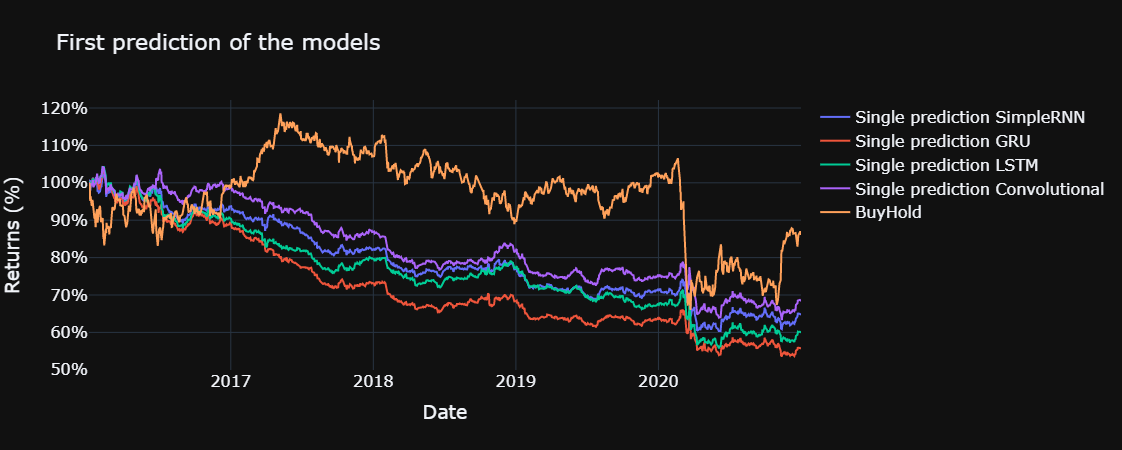

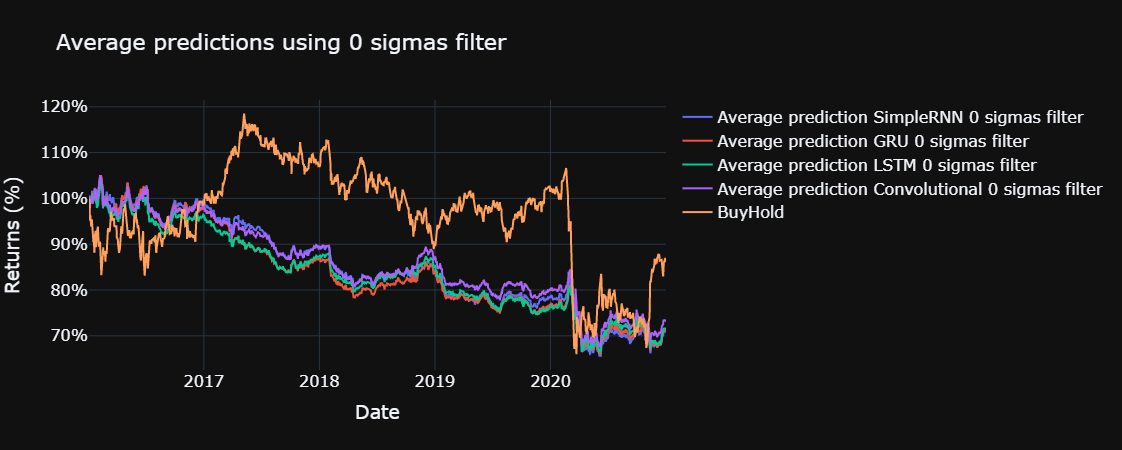

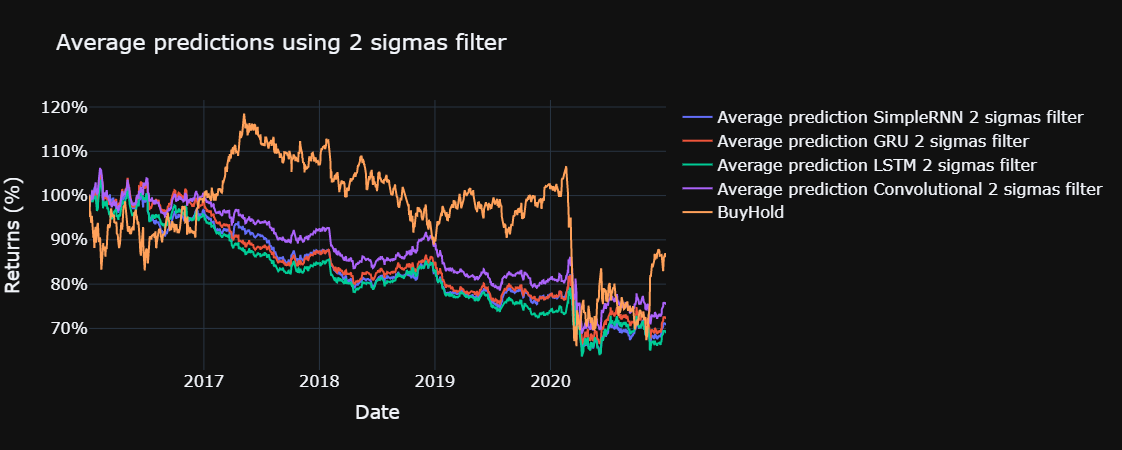

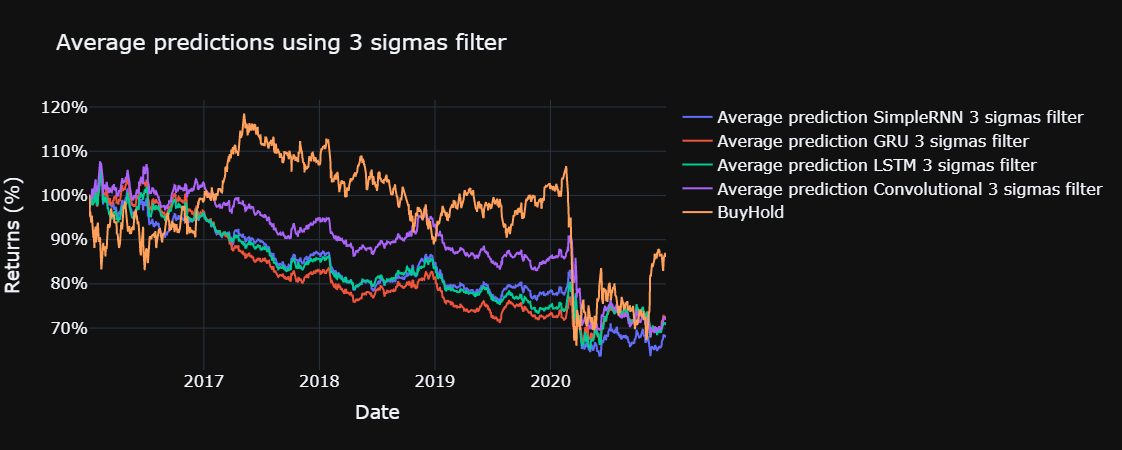

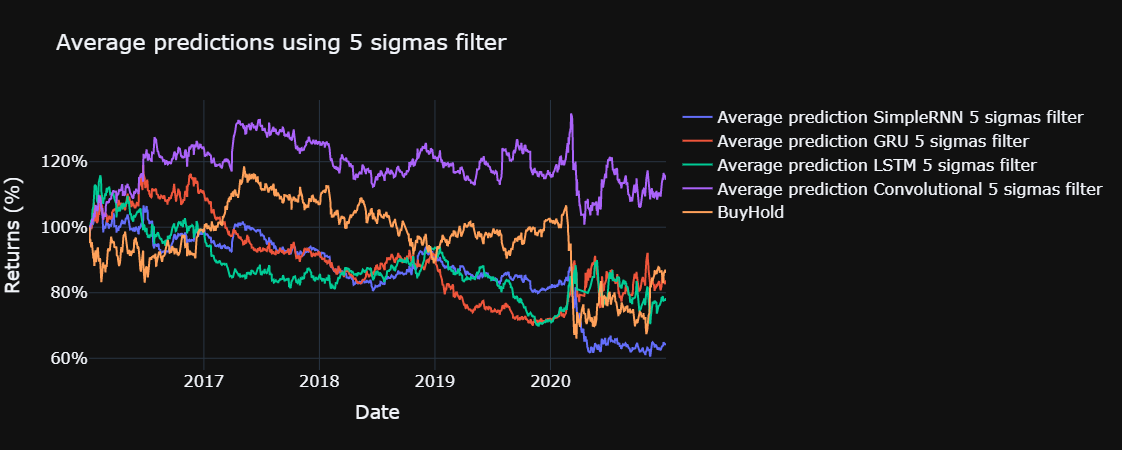

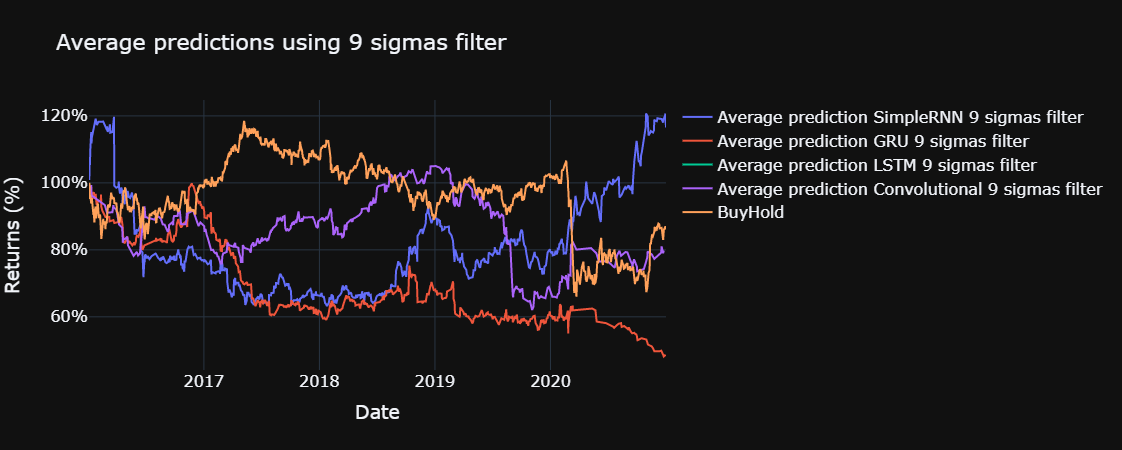

In [61]:
plot_returns(title = "First prediction of the models", mean = False)
for std in sigmas:
    plot_returns(title = f"Average predictions using {std} sigmas filter", single = False, std = std)

The yearly sharpe ratio, sortino ratio and the information ratio are computed for each model, using the functions defined below. The risk free return is assumed to be 0 % and the benchmark for the information ratio is the return obtained through buy and hold in the Ibex 35, excluding commissions, during the test set. 

In [62]:
def sharpe_ratio(returns):
    return np.sqrt(returns.groupby(returns.index.year).count().mean()) * (returns - 1).mean() / (returns - 1).std()

def information_rate(returns, benchmark):
    return (returns - benchmark).mean() / (returns - benchmark).std()

def sortino_ratio(returns):
    return np.sqrt(returns.groupby(returns.index.year).count().mean()) * (returns - 1).mean() / (returns[(returns -1) < 0] - 1).std()

We store the results of our models in a DataFrame

In [63]:
date = "2016"
df_rets = pd.DataFrame(columns = ["Sharpe ratio", "IR", "Sortino ratio"], dtype = np.float64)
for i, ret in enumerate(rets_mean):
    ret = ret.loc[date:]
    rets_b = rets_b.loc[date:]
    df_rets.loc[names_mean[i]] = sharpe_ratio(ret), information_rate(ret, rets_b), sortino_ratio(ret)
    
for i, ret in enumerate(rets_single):
    ret = ret.loc[date:]
    rets_b = rets_b.loc[date:]
    df_rets.loc[names_single[i]] = sharpe_ratio(ret), information_rate(ret, rets_b), sortino_ratio(ret)
df_rets.loc["buyhold"] = sharpe_ratio(rets_b.loc[date:]), 0, sortino_ratio(rets_b.loc[date:])

Finally we show the results of this DataFrame sorted by its sharpe ratio.

In [64]:
df_rets.sort_values(by = "Sharpe ratio", ascending = False)

Sharpe ratio        IR  \
Average prediction Convolutional 5 sigmas filter      0.092384       NaN   
Average prediction SimpleRNN 9 sigmas filter         -0.046515       NaN   
buyhold                                              -0.046698  0.000000   
Average prediction GRU 5 sigmas filter               -0.097576       NaN   
Average prediction LSTM 5 sigmas filter              -0.247993       NaN   
Average prediction GRU 3 sigmas filter               -0.352011 -0.013554   
Average prediction Convolutional 2 sigmas filter     -0.358399 -0.011557   
Average prediction LSTM 3 sigmas filter              -0.366598 -0.014486   
Average prediction Convolutional 9 sigmas filter     -0.377053       NaN   
Average prediction GRU 2 sigmas filter               -0.383761 -0.013945   
Average prediction LSTM 2 sigmas filter              -0.420939 -0.016108   
Average prediction Convolutional 0 sigmas filter     -0.440384 -0.013667   
Average prediction LSTM 0 sigmas filter              -0.449887 -0.014953   
Average prediction Convolutional 3 sigmas filter     -0.461838 -0.013918   
Average prediction SimpleRNN 2 sigmas filter         -0.482595 -0.015142   
Average prediction GRU 0 sigmas filter               -0.497236 -0.015416   
Average prediction SimpleRNN 0 sigmas filter         -0.503461 -0.015658   
Average prediction SimpleRNN 3 sigmas filter         -0.522012 -0.017348   
Average prediction SimpleRNN 5 sigmas filter         -0.549025 -0.018619   
Single prediction Convolutional                      -0.581178 -0.017342   
Single prediction SimpleRNN                          -0.718020 -0.020905   
Average prediction GRU 9 sigmas filter               -0.743201       NaN   
Single prediction LSTM                               -0.764457 -0.024868   
Single prediction GRU                                -0.887551 -0.029209   
Average prediction LSTM 9 sigmas filter                    NaN       NaN   

                                                  Sortino ratio  
Average prediction Convolutional 5 sigmas filter       0.127234  
Average prediction SimpleRNN 9 sigmas filter          -0.060363  
buyhold                                               -0.060459  
Average prediction GRU 5 sigmas filter                -0.142882  
Average prediction LSTM 5 sigmas filter               -0.324038  
Average prediction GRU 3 sigmas filter                -0.442145  
Average prediction Convolutional 2 sigmas filter      -0.448631  
Average prediction LSTM 3 sigmas filter               -0.448272  
Average prediction Convolutional 9 sigmas filter      -0.505655  
Average prediction GRU 2 sigmas filter                -0.476749  
Average prediction LSTM 2 sigmas filter               -0.512820  
Average prediction Convolutional 0 sigmas filter      -0.541892  
Average prediction LSTM 0 sigmas filter               -0.553452  
Average prediction Convolutional 3 sigmas filter      -0.564846  
Average prediction SimpleRNN 2 sigmas filter          -0.598390  
Average prediction GRU 0 sigmas filter                -0.618532  
Average prediction SimpleRNN 0 sigmas filter          -0.620316  
Average prediction SimpleRNN 3 sigmas filter          -0.652466  
Average prediction SimpleRNN 5 sigmas filter          -0.647886  
Single prediction Convolutional                       -0.716227  
Single prediction SimpleRNN                           -0.884609  
Average prediction GRU 9 sigmas filter                -1.003819  
Single prediction LSTM                                -0.943017  
Single prediction GRU                                 -1.090663  
Average prediction LSTM 9 sigmas filter                     NaN

#### Saving data
It took a long time to generate our models and train them, let's keep the data we can keep in a [pickle](https://docs.python.org/3/library/pickle.html) file.

In [107]:
# need to ' pip install pickle-mixin '
import pickle
import inspect # Needed to check what object is or isn't a module object; pickle cannot 'pickle' module objects.

In [120]:
alll, alll_err, alll_names = [[], []], [], []
pickle_out = open("MCDropout_005_module_test.pickle","wb")
for i in dir():
    try:
        exec(f"pickle.dump({i}, pickle_out)")
        alll_names.append(i)
    except:
        alll_err.append(i)
pickle_out.close()

for i in alll_names:
    alll[0].append(i)
    exec(f"alll[1].append({i})")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:18,777 P[23380] [MainThread 10316] AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000029B9A320438> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:19,257 P[23380] [MainThread 10316] AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000029B9A1FBCA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://65009742-b77a-4ca7-b29e-25a0c62beb60/assets


2021-12-01 14:50:20,019 P[23380] [MainThread 10316] Assets written to: ram://65009742-b77a-4ca7-b29e-25a0c62beb60/assets


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:20,078 P[23380] [MainThread 10316] AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000029B9A49AE58> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:20,465 P[23380] [MainThread 10316] AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000029B9A427AF8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://fd7b035e-c2eb-4860-9603-617d77d2d57b/assets


2021-12-01 14:50:21,147 P[23380] [MainThread 10316] Assets written to: ram://fd7b035e-c2eb-4860-9603-617d77d2d57b/assets


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:21,197 P[23380] [MainThread 10316] AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000029B9A738828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:22,130 P[23380] [MainThread 10316] AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000029B9AA175E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://ce0eb921-8b52-404f-9e33-c3d7e161ba6a/assets


2021-12-01 14:50:23,602 P[23380] [MainThread 10316] Assets written to: ram://ce0eb921-8b52-404f-9e33-c3d7e161ba6a/assets


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:23,690 P[23380] [MainThread 10316] AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000029B9C9795E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:24,078 P[23380] [MainThread 10316] AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000029B9A25ACA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://f6e1b5b2-a943-4655-aa55-316f93a96d1c/assets


2021-12-01 14:50:24,773 P[23380] [MainThread 10316] Assets written to: ram://f6e1b5b2-a943-4655-aa55-316f93a96d1c/assets


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:24,822 P[23380] [MainThread 10316] AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000029B9A8CE1F8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:25,206 P[23380] [MainThread 10316] AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000029B9A859828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://3b1406b7-88ba-4872-a04b-19813229fcce/assets


2021-12-01 14:50:25,912 P[23380] [MainThread 10316] Assets written to: ram://3b1406b7-88ba-4872-a04b-19813229fcce/assets


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:25,958 P[23380] [MainThread 10316] AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000029B9F376CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 14:50:27,286 P[23380] [MainThread 10316] AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000029B9F460318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://7d19a355-df61-4a30-b8e1-5a77371d23e7/assets


2021-12-01 14:50:28,734 P[23380] [MainThread 10316] Assets written to: ram://7d19a355-df61-4a30-b8e1-5a77371d23e7/assets


In [138]:
# To save data out:
pickle_out = open("MCDropout_005.pickle","wb") # This creates the '.pickle' file where our data of choice will be saved. ' wb ' stand for 'write bytes'.
pickle.dump(alll, pickle_out) # ' pickle_out ' specifies the '.pickle' file in which we want to write (actually: overwrite - everything previously in that file will be overwritten)
pickle_out.close() # We need to close this '.pickle' file; leaving it open could corrupt it.

# # To load data in:
# pickle_in = open("MCDropout_005.pickle","rb") # ' rb ' stand for 'read bytes'.
# allll = pickle.load(pickle_in)
# pickle_in.close() # We ought to close the file we opened to allow any other programs access if they need it.

### 4. Conclusions

By modelling the uncertainty through the standard deviation of the predictions it is possible to obtain better results than using a single prediction. In addition, a few models could generate positive returns in the test set, even when incorporating trading commissions.

Moreover, these models only used an input based on the raw percentage change of prices scaled and the addition of some statistical measures of the returns on the sequences of 22 days. However, other inputs such as fundamental data, or even some transformations of the data might produce much better results. 

Furthermore, even though the convolutional layer performs better than the simple recurrent neural network cells, the simple RNN outperformed it with the filter of highest standard deviations (9 in this case). However, the convolutional model using 5 standard deviations as filter obtained a better positive information ratio while the GRU with the same filter produced a negative one.

To sum up, incorporating MC dropout for the predictions of deep learning has shown a great effect for predicting returns for the historical constituents of the Ibex 35.


#### Future lines of work

Most of the models lost money on the test set even while ignoring trading commissions, thus more informative inputs might produce much better results. In addition, given that the predicted returns were divided by the sum of the absolute of the predictions for that date, using sequences of data for all the stocks and predicting a relative value for each of them might yield better results.

Other methods for modelling uncertainty in predictions might be explored and compared with this methodology. In addition, performing more predictions under this methodology would produce a better estimation of the standard deviation of the predictions, although it requires high computing capacity, given that the predictions took more time than training the models.


## Bibliography

Abe, M. and Nakayama, H., 2018. Deep Learning for Forecasting Stock Returns in the Cross-Section. In: D. Phung, V.S. Tseng, G.I. Webb, B. Ho, M. Ganji and L. Rashidi, eds. Advances in Knowledge Discovery and Data Mining, Lecture Notes in Computer Science. Cham: Springer International Publishing.pp.273–284. https://doi.org/10.1007/978-3-319-93034-3_22.

Baldi, P. and Sadowski, P.J., n.d. Understanding Dropout. p.9.

Brach, K., Sick, B. and Dürr, O., 2020. Single Shot MC Dropout Approximation. arXiv:2007.03293 [cs, stat]. [online] Available at: <http://arxiv.org/abs/2007.03293> [Accessed 7 Mar. 2021].

Chen, S. and He, H., 2018. Stock Prediction Using Convolutional Neural Network. IOP Conference Series: Materials Science and Engineering, 435, p.012026. https://doi.org/10.1088/1757-899X/435/1/012026.

Clevert, D.-A., Unterthiner, T. and Hochreiter, S., 2016. Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs). arXiv:1511.07289 [cs]. [online] Available at: <http://arxiv.org/abs/1511.07289> [Accessed 31 Jan. 2021].

Fischer, T. and Krauss, C., 2018. Deep learning with long short-term memory networks for financial market predictions. European Journal of Operational Research, 270(2), pp.654–669. https://doi.org/10.1016/j.ejor.2017.11.054.

Gal, Y. and Ghahramani, Z., 2016. Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. arXiv:1506.02142 [cs, stat]. [online] Available at: <http://arxiv.org/abs/1506.02142> [Accessed 7 Mar. 2021].

Goodwin, T.H., 1998. The Information Ratio. Financial Analysts Journal, 54(4), pp.34–43. https://doi.org/10.2469/faj.v54.n4.2196.

Ioffe, S. and Szegedy, C., 2015. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. arXiv:1502.03167 [cs]. [online] Available at: <http://arxiv.org/abs/1502.03167> [Accessed 3 Feb. 2021].

Kiranyaz, S., Avci, O., Abdeljaber, O., Ince, T., Gabbouj, M. and Inman, D.J., 2021. 1D convolutional neural networks and applications: A survey. Mechanical Systems and Signal Processing, 151, p.107398. https://doi.org/10.1016/j.ymssp.2020.107398.

Molchanov, D., Ashukha, A. and Vetrov, D., 2017. Variational Dropout Sparsifies Deep Neural Networks. arXiv:1701.05369 [cs, stat]. [online] Available at: <http://arxiv.org/abs/1701.05369> [Accessed 8 Mar. 2021].

Nabipour, M., Nayyeri, P., Jabani, H., Mosavi, A., Salwana, E. and S., S., 2020. Deep Learning for Stock Market Prediction. Entropy, 22(8), p.840. https://doi.org/10.3390/e22080840.

Sayavong, L., Wu, Z. and Chalita, S., 2019. Research on Stock Price Prediction Method Based on Convolutional Neural Network. In: 2019 International Conference on Virtual Reality and Intelligent Systems (ICVRIS). 2019 International Conference on Virtual Reality and Intelligent Systems (ICVRIS). pp.173–176. https://doi.org/10.1109/ICVRIS.2019.00050.

Sharpe, W.F., 1994. The Sharpe Ratio. The Journal of Portfolio Management, 21(1), pp.49–58. https://doi.org/10.3905/jpm.1994.409501.

Sortino, F.A. and Price, L.N., 1994. Performance Measurement in a Downside Risk Framework. The Journal of Investing, 3(3), pp.59–64. https://doi.org/10.3905/joi.3.3.59.

## References

[Uncertainty in Neural Networks? Monte Carlo Dropout](https://www.youtube.com/watch?v=eHT0raFtl1Q)